In [1]:
from insightface.model_zoo import model_zoo
from insightface.app.common import Face
from glob import glob
from tqdm import tqdm
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from insightface.app import FaceAnalysis
from predict_face import pred_face, draw_on

/home/feliks/Documents/faceid/venv/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


/home/feliks/Documents/faceid/venv/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/buffalo_l/det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: ./models/buffalo_l/w600k_mbf.onnx recognition
set det-size: (640, 640)
[('feliks', 22, 'M')]
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/buffalo_l/det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: ./models/buffal

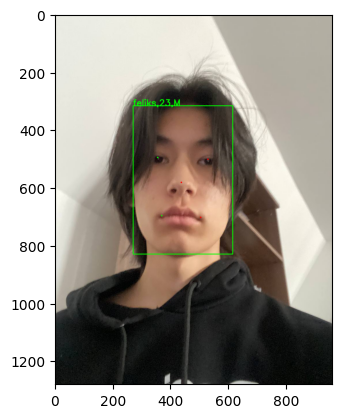

In [2]:
app = FaceAnalysis(allowed_modules=['detection', 'genderage'], root = './')
app.prepare(ctx_id=0 ,det_size=(640,640))

img_path = '/home/feliks/Downloads/photo_5256188845681137684_y.jpg'
img = cv2.imread(img_path)

faces = app.get(img)


print(pred_face(img_path))

img, names = draw_on(img_path)
plt.imshow(img[:,:,::-1])

In [2]:
det_model_path = 'buffalo_s/det_500m.onnx'
rec_model_path = 'buffalo_s/w600k_mbf.onnx'
gender_age_model_path = 'buffalo_s/genderage.onnx'

det_model = model_zoo.get_model(f'./models/{det_model_path}')
rec_model = model_zoo.get_model(f'./models/{rec_model_path}')
gender_age = model_zoo.get_model(f'./models/{gender_age_model_path}')

det_model.prepare(ctx_id=0, input_size=(640, 640), det_thres=0.5)

/home/feliks/Documents/faceid/venv/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


In [3]:
known_names, unknown_names = [], []
known_embeddings, unknown_embeddings = [], []

db_faces_path = './data/db'
players = os.listdir(db_faces_path)
for player in tqdm(players):
    player_embeddings, player_names = [], []

    img_paths = glob(f'{db_faces_path}/{player}/*')
    for img_path in img_paths:
        img = cv2.imread(img_path)
        if img is None: continue

        bboxes, kpss = det_model.detect(img, max_num=0, metric='defualt')
        if len(bboxes) != 1: continue

        bbox = bboxes[0, :4]
        det_score = bboxes[0, 4]
        kps = kpss[0]
        face = Face(bbox=bbox, kps=kps, det_score=det_score)

        rec_model.get(img, face)
        player_embeddings.append(face.normed_embedding)
        player_names.append(player)
        if len(player_embeddings) == 10: break
    
    player_embeddings = np.stack(player_embeddings, axis=0)
    known_embeddings.append(player_embeddings[0:5])
    unknown_embeddings.append(player_embeddings[5:10])
    known_names += player_names[0:5]
    unknown_names += player_names[5:10]

known_embeddings = np.concatenate(known_embeddings, axis=0)
unknown_embeddings = np.concatenate(unknown_embeddings, axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


In [6]:
def search_flatten(known_embeddings, known_names, unknown_embeddings, threshold=0.5):
    pred_names = []
    for emb  in unknown_embeddings:
        scores = np.dot(emb, known_embeddings.T)
        scores = np.clip(scores, 0., 1.)

        idx = np.argmax(scores)
        score = scores[idx]
        if score > threshold:
            pred_names.append(known_names[idx])
        else:
            pred_names.append(None)
    
    return pred_names

In [15]:
# Load the new image
app = FaceAnalysis(allowed_modules=['detection', 'genderage'], root = './')
app.prepare(ctx_id=0 ,det_size=(640,640))
new_image_path = '/home/feliks/Downloads/photo_5256188845681137684_y.jpg'
new_image = cv2.imread(new_image_path)
gender = ['F' ,'M']
# Use the face detection model to detect faces
bboxes, kpss = det_model.detect(new_image, max_num=0, metric='default')

# Initialize lists to store results
detected_names = []
for i, bbox in enumerate(bboxes):
    # Extract bounding box coordinates
    bbox = bbox[:4]
    x, y, width, height = bbox.astype(int)
    cv2.rectangle(new_image, (x,y), (width, height), (0, 255, 0) , 2)
    
    # Create a Face object
    face = Face(bbox=bbox, kps=kpss[i])

    # Use the recognition model to obtain the face embedding
    rec_model.get(new_image, face)
    gender_age.get(new_image, face)
    new_embedding = face.normed_embedding
    drow = app.draw_on(img, [face])

    # Use the search function to predict the name
    # You can choose either search_flatten or search_average based on your preference
    pred_name = search_flatten(known_embeddings, known_names, [new_embedding])[0]

    # Store the result
    detected_names.append(pred_name)
    cv2.putText(new_image, f'{detected_names[i]},{face["age"]},{gender[face["gender"]]}', (x,y), cv2.FONT_HERSHEY_SIMPLEX ,  
                1, (0, 255, 0), 2, cv2.LINE_AA) 

# Print the detected names
print("Detected Names:", detected_names)

/home/feliks/Documents/faceid/venv/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: ./models/buffalo_s/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: ./models/buffalo_s/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/buffalo_s/det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/buffalo_s/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: ./models/buffalo_s/w600k_mbf.onnx recognition
set det-size: (640, 640)
Detected Names: ['verify']
